In [1]:
import os
import shutil
import json
import yaml
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

# Define paths
BASE_DIR = Path(os.getcwd())
COCO_DIR = BASE_DIR / "signs_coco"
IMAGES_SOURCE_DIR = COCO_DIR / "images" 

JSON_FILE = BASE_DIR / "signs.json"

# Output directories for the new YOLO dataset
YOLO_DATA_DIR = BASE_DIR / "yolo_dataset_condition"
TRAIN_IMG_DIR = YOLO_DATA_DIR / "images" / "train"
VAL_IMG_DIR = YOLO_DATA_DIR / "images" / "val"
TRAIN_LBL_DIR = YOLO_DATA_DIR / "labels" / "train"
VAL_LBL_DIR = YOLO_DATA_DIR / "labels" / "val"

for d in [TRAIN_IMG_DIR, VAL_IMG_DIR, TRAIN_LBL_DIR, VAL_LBL_DIR]:
    d.mkdir(parents=True, exist_ok=True)
    
print("Directories created for Sign Condition task.")


Directories created for Sign Condition task.


In [2]:
def convert_label_studio_to_yolo(json_path):
    with open(json_path, 'r') as f:
        tasks = json.load(f)
    
    # Define our target classes
    # Condition mapping: Lowercase -> ID
    condition_map = {
        "good": 0,
        "weathered": 1,
        "damaged": 2,
        "heavily damaged": 3
    }
    class_names = ["Good", "Weathered", "Heavily Damaged"]
    
    processed_files = []
    stats = {"success": 0, "skipped_no_img": 0, "skipped_no_cond": 0}
    
    print(f"Processing {len(tasks)} tasks from Label Studio export...")
    
    for task in tasks:
        # Get Filename
        if 'data' in task and 'image' in task['data']:
            image_path = task['data']['image']
        elif 'file_upload' in task:
             image_path = task['file_upload']
        else:
            continue
            
        file_name = os.path.basename(image_path)
        
        # Check if we actually have this image on disk
        found_src_path = None
        if (IMAGES_SOURCE_DIR / file_name).exists():
             found_src_path = IMAGES_SOURCE_DIR / file_name
        else:
            # Fallback: Try to match by checking if the file ends with the same name
            for f in IMAGES_SOURCE_DIR.iterdir():
                if f.name.endswith(file_name) or file_name.endswith(f.name):
                    found_src_path = f
                    break
        
        if not found_src_path:
            stats['skipped_no_img'] += 1
            continue

        # Group Results by ID
        results = task.get('annotations', [{}])[0].get('result', [])
        
        objects_by_id = {}
        for res in results:
            rid = res.get('id')
            if not rid: continue
            
            if rid not in objects_by_id:
                objects_by_id[rid] = {'bbox': None, 'condition': None}
            
            if res['type'] == 'rectanglelabels':
                objects_by_id[rid]['bbox'] = res['value']
            
            if res['from_name'] == 'sign_condition':
                choices = res['value'].get('choices', [])
                if choices:
                    objects_by_id[rid]['condition'] = choices[0]
        
        # Create YOLO Labels
        label_lines = []
        for rid, obj in objects_by_id.items():
            if obj['bbox'] and obj['condition']:
                cond_str = obj['condition'].lower()
                
                if cond_str not in condition_map:
                    continue
                
                cls_idx = condition_map[cond_str]
                
                x = obj['bbox']['x']
                y = obj['bbox']['y']
                w = obj['bbox']['width']
                h = obj['bbox']['height']
                
                x_center = (x + w / 2) / 100.0
                y_center = (y + h / 2) / 100.0
                width_norm = w / 100.0
                height_norm = h / 100.0
                
                label_lines.append(f"{cls_idx} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}")
            else:
                if obj['bbox'] and not obj['condition']:
                    stats['skipped_no_cond'] += 1

        if label_lines:
            processed_files.append({
                'src_path': found_src_path, 
                'file_name': file_name,
                'labels': label_lines
            })
            stats['success'] += 1
            
    print("\n--- Conversion Report ---")
    print(f"Processed Tasks: {len(tasks)}")
    print(f"Successfully Converted: {stats['success']} images")
    print(f"Skipped (Image not found): {stats['skipped_no_img']}")
    print(f"Skipped (No condition label): {stats['skipped_no_cond']} (individual boxes)")
    
    return processed_files, class_names

files_data, class_names = convert_label_studio_to_yolo(JSON_FILE)
print(f"Classes: {class_names}")

if len(files_data) == 0:
    raise ValueError("No images converted! Check that 'signs.json' paths match files in 'signs_coco/images'")


Processing 602 tasks from Label Studio export...

--- Conversion Report ---
Processed Tasks: 602
Successfully Converted: 602 images
Skipped (Image not found): 0
Skipped (No condition label): 0 (individual boxes)
Classes: ['Good', 'Weathered', 'Heavily Damaged']


In [3]:
# Split into train and validation sets
train_files, val_files = train_test_split(files_data, test_size=0.2, random_state=42)

def save_split(split_data, img_dest, lbl_dest):
    for item in split_data:
        shutil.copy(item['src_path'], img_dest / item['file_name'])
        
        txt_name = os.path.splitext(item['file_name'])[0] + ".txt"
        with open(lbl_dest / txt_name, 'w') as f:
            f.write("\n".join(item['labels']))

print("Saving Training set...")
save_split(train_files, TRAIN_IMG_DIR, TRAIN_LBL_DIR)

print("Saving Validation set...")
save_split(val_files, VAL_IMG_DIR, VAL_LBL_DIR)

print("Data preparation complete.")


Saving Training set...
Saving Validation set...
Data preparation complete.


In [4]:
# Configuration
yaml_content = f"""
path: {YOLO_DATA_DIR.absolute()} 
train: images/train
val: images/val

nc: {len(class_names)}
names: {class_names}
"""

with open("dataset_condition.yaml", "w") as f:
    f.write(yaml_content)

print("dataset_condition.yaml created.")


dataset_condition.yaml created.


In [5]:
model = YOLO("yolov8n.pt")  # using yolo v8 nano but for sign condition

results = model.train(
    data="dataset_condition.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    device=0,
    name="sign_condition_yolov8"
)

print("Training finished!")


New https://pypi.org/project/ultralytics/8.4.9 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.4.8 🚀 Python-3.13.11 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11867MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_condition.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=sign_con

/home/nix/git/CV-Signs/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1818.0±1000.1 MB/s, size: 2227.9 KB)
val: Scanning /home/nix/git/CV-Signs/yolo_dataset_condition/labels/val.cache... 121 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 121/121 10.2Mit/s 0.0s
Plotting labels to /home/nix/git/CV-Signs/runs/detect/sign_condition_yolov83/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/nix/git/CV-Signs/runs/detect/sign_condition_yolov83
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/50      2.12G     0.7643      2.508       1.05          3        640: 100% ━━━━━━━━━━━━ 31/31 1.2it/s 26.1s0.3s
           


image 1/1 /home/nix/git/CV-Signs/yolo_dataset_condition/images/val/a8f57bf9-IMG_20251125_195707.jpg: 640x480 1 Weathered, 4.7ms
Speed: 1.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


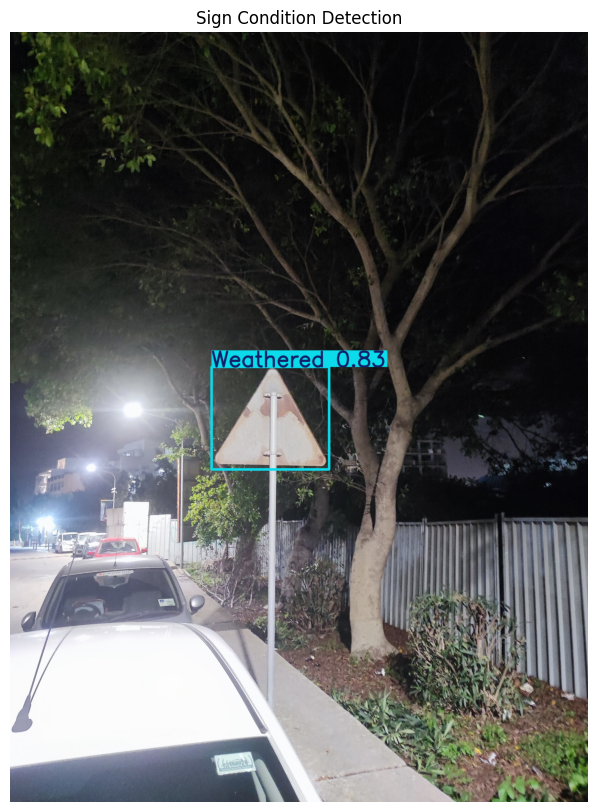

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import random

# random image from the validation set
val_images = list(VAL_IMG_DIR.glob("*.jpg")) + list(VAL_IMG_DIR.glob("*.jpeg"))
test_img = random.choice(val_images)

results = model.predict(test_img, conf=0.25)
res_plotted = results[0].plot()
res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(res_rgb)
plt.axis('off')
plt.title("Sign Condition Detection")
plt.show()
